#Task
- Classify the FMNIST dataset
- the images are 28x28 grayscale images
- plot train/val/test loss and accuracy


In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset, Subset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-20-8f26e3a3cffb>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transforms)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
val_loader   = DataLoader(devset,  batch_size=batchsize) # note: devtest in batches!
test_loader  = DataLoader(testset, batch_size=len(testset))


In [ ]:
trainset.classes, len(trainset.classes)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

In [28]:
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(devset) )
print( len(testset) )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(trainset.data),torch.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
60000
6000
4000

Data value range:
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [29]:
# but...
X,y = next(iter(test_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([4000, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))


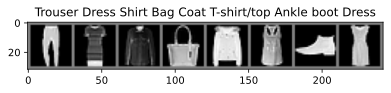

In [30]:
images, labels = next(iter(train_loader))
images_subset = images[:8]
labels_subset = labels[:8]

# Create a grid of the selected images and plot
grid_img = torchvision.utils.make_grid(images_subset, nrow=8)
plt.imshow(grid_img.permute(1, 2, 0) / 2 + 0.5)
plt.title(' '.join(trainset.classes[label] for label in labels_subset))
plt.show()
imgSize = images.shape[2]

In [ ]:
# create a class for the model
def makeTheNet():

  class emnistnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1  = nn.Conv2d(in_channels=1,
                              out_channels=64,
                              kernel_size=3,
                              padding=1)
      self.bnorm1 = nn.BatchNorm2d(self.conv1.out_channels)

      self.conv2  = nn.Conv2d(in_channels=self.bnorm1.num_features,
                              out_channels=128,
                              kernel_size=3,
                              padding=1)
      self.bnorm2 = nn.BatchNorm2d(self.conv2.out_channels)

      self.conv3  = nn.Conv2d(in_channels=self.bnorm2.num_features,
                                    out_channels=256,
                                    kernel_size=3,
                                    padding=1)
      self.bnorm3 = nn.BatchNorm2d(self.conv3.out_channels) # input the number of channels in this layer

      conv1postPool = int((np.floor((imgSize + (2*self.conv1.padding[0]) - self.conv1.kernel_size[0])/self.conv1.stride[0]) + 1)/2)
      conv2postPool = int((np.floor((conv1postPool + (2*self.conv2.padding[0]) - self.conv2.kernel_size[0])/self.conv2.stride[0]) + 1)/2)
      conv3postPool = int((np.floor((conv2postPool + (2*self.conv2.padding[0]) - self.conv3.kernel_size[0])/self.conv3.stride[0]) + 1)/2)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(conv3postPool**2 * self.bnorm3.num_features,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64, len(trainset.classes))


    def forward(self,x):

      # first block
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x, p=0.2, training=self.training)
      # Second block
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x, p=0.2, training=self.training)

      # thrid block
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x, p=0.2, training=self.training)

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x, p=0.5, training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x, p=0.5, training=self.training)
      x = self.fc3(x)
      return x

  # create the model instance
  net = emnistnet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001, weight_decay = 0.02)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3090, grad_fn=<NllLossBackward0>)


In [ ]:
# a function that trains the model

def trainTheModel(net,lossfun,optimizer, train_loader, val_loader):

  # number of epochs
  numepochs = 10

  # create a new model

  # initialize losses
  trainLosses    = torch.zeros(numepochs)
  valLosses    = torch.zeros(numepochs)
  trainAcc  = []
  valAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    trainLosses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    valBatchAcc  = []
    valBatchLoss = []
    for X,y in val_loader:
      X = X.to(device)
      y = y.to(device)
      X,y = next(iter(test_loader)) # extract X,y from test dataloader
      with torch.no_grad(): # deactivates autograd
        yHat = net(X)
        loss = lossfun(yHat, y)

      valBatchLoss.append(loss.item())

      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      valBatchAcc.append( accuracyPct )
      # compare the following really long line of code to the training accuracy lines

    valAcc.append( np.mean(valBatchAcc) )
    valLosses[epochi] = np.mean(valBatchLoss)

  # end epochs

  # function output
  return trainAcc,valAcc,trainLosses,valLosses,net


In [ ]:
net,lossfun,optimizer = makeTheNet()

trainAcc,valAcc,trainLosses,valLosses,net = trainTheModel(net,lossfun,optimizer, train_loader,val_loader)

In [ ]:
net.eval()
X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)
testLoss = loss.item()
testAcc = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(5,6))

testepoch = len(trainAcc)

ax[0].plot(trainLosses,'s-',label='Train')
ax[0].plot(valLosses,'o-',label='Test')
ax[0].scatter(testepoch, testLoss, color='red',marker='*', label='Test Accuracy', s=50)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(valAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model val/test accuracy rate: {valAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].scatter(testepoch, testAcc, color='red',marker='*', label='Test Accuracy', s=50)
ax[1].legend()

plt.tight_layout()
plt.show()